In [2]:
import GOES
from netCDF4 import Dataset
from pyproj import Proj
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


In [4]:

"""

download=GOES.download('goes16', 'ABI-L1b-RadF',
              DateTimeIni = '20200320-060000', DateTimeFin = '20200320-070000',
                channel = ['13'], rename_fmt = '%Y%m%d%H%M%S', path_out='data_prueba1/')

"""



Files:
  OR_ABI-L1b-RadF-M6C13_G16_s20200320060018.nc 100% 29.9MB 6s
  OR_ABI-L1b-RadF-M6C13_G16_s20200320061018.nc 100% 29.9MB 8s
  OR_ABI-L1b-RadF-M6C13_G16_s20200320062018.nc 100% 29.9MB 9s
  OR_ABI-L1b-RadF-M6C13_G16_s20200320063018.nc 100% 29.9MB 7s
  OR_ABI-L1b-RadF-M6C13_G16_s20200320064018.nc 100% 30.0MB 6s
  OR_ABI-L1b-RadF-M6C13_G16_s20200320065018.nc 100% 30.0MB 8s


In [4]:
ds8 = Dataset('data_prueba1/OR_ABI-L1b-RadF-M6C08_G16_s20200320060018.nc')
ds9 = Dataset('data_prueba1/OR_ABI-L1b-RadF-M6C09_G16_s20200320060018.nc')
ds10 = Dataset('data_prueba1/OR_ABI-L1b-RadF-M6C10_G16_s20200320060018.nc')
ds13 = Dataset('data_prueba1/OR_ABI-L1b-RadF-M6C13_G16_s20200320060018.nc')
ds14 = Dataset('data_prueba1/OR_ABI-L1b-RadF-M6C14_G16_s20200320060018.nc')

In [10]:
ds8

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: RBU
    production_environment: OE
    spatial_resolution: 2km at nadir
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Full Disk
    instrument_ID: FM1
    title: ABI L1b Radiances
    summary: Single emissive band ABI L1b Radiance Products are digital maps of outgoing radiance values at the top of the atmosphere for IR bands.
    keywords: SPECTRAL/ENGINEERING > INFRARED WAVELENGTHS > INFRARED RADIANCE
    keywords_vocabular

## RECORTE

El recorte se puede hacer con una sola imagen

In [5]:

sat_h= ds8.variables['goes_imager_projection'].perspective_point_height
sat_lon = ds8.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = ds8.variables['goes_imager_projection'].sweep_angle_axis

gip = ds8.variables['goes_imager_projection']

x = ds8.variables['x'][:]
y = ds8.variables['y'][:]

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

bound = {'lon': [-81.03,-64], 
         'lat': [-4.1,12.78]}

xmin,ymin = p(bound['lon'][0],bound['lat'][0])/sat_h
xmax,ymax = p(bound['lon'][1],bound['lat'][1])/sat_h

# Creamos unos arreglos que indican las posiciones en los arreglos de x e y
# que estan dentro del area
sel_x = np.where((x>=xmin) & (x<=xmax))
sel_y = np.where((y>=ymin) & (y<=ymax))

x_col = x[sel_x]
y_col = x[sel_y]

Rad8 = ds8.variables['Rad'][sel_y[0].min():sel_y[0].max()+1,sel_x[0].min():sel_x[0].max()+1]
Rad9 = ds9.variables['Rad'][sel_y[0].min():sel_y[0].max()+1,sel_x[0].min():sel_x[0].max()+1]
Rad10 = ds10.variables['Rad'][sel_y[0].min():sel_y[0].max()+1,sel_x[0].min():sel_x[0].max()+1]
Rad13 = ds13.variables['Rad'][sel_y[0].min():sel_y[0].max()+1,sel_x[0].min():sel_x[0].max()+1]
Rad14 = ds14.variables['Rad'][sel_y[0].min():sel_y[0].max()+1,sel_x[0].min():sel_x[0].max()+1]

x_, y_ = np.meshgrid(x_col*sat_h, y_col*sat_h)
lon_colombia, lat_colombia = p(x_, y_, inverse=True)

lon_colombia_=lon_colombia[0]
lat_colombia_=lat_colombia[:,0]

In [4]:
lon_colombia_.data.shape

(920,)

In [6]:
lat_colombia_.data.shape


(920,)

In [7]:
x_par = {'scale_factor': ds8.variables['x'].scale_factor,
            'add_offset': ds8.variables['x'].add_offset,
            'units': 'rad',
            'axis': 'X'}
    
y_par = {'scale_factor': ds8.variables['y'].scale_factor,
            'add_offset': ds8.variables['y'].add_offset,
            'units': 'rad',
            'axis': 'Y'}


ds = Dataset('RadF_20200320060018.nc','w',format='NETCDF4')
dsinfo = Dataset('info.nc','w',format='NETCDF4')

ds.createDimension('y',len(y_col))
ds.createDimension('x',len(x_col))

dsinfo.createDimension('y',len(y_col))
dsinfo.createDimension('x',len(x_col))
    
#Agregar variables
ys = dsinfo.createVariable('y','i2',('y',))
xs = dsinfo.createVariable('x','i2',('x',))
    
ys.setncatts({k: ds8.variables['y'].getncattr(k) for k in ds8.variables['y'].ncattrs()})
xs.setncatts({k: ds8.variables['x'].getncattr(k) for k in ds8.variables['x'].ncattrs()})
    
fill = ds8.variables['Rad']._FillValue    

dsRad8 = ds.createVariable('Rad8','i2',('y','x',),fill_value=fill)
dsRad9 = ds.createVariable('Rad9','i2',('y','x',),fill_value=fill)
dsRad10 = ds.createVariable('Rad10','i2',('y','x',),fill_value=fill)
dsRad13 = ds.createVariable('Rad13','i2',('y','x',),fill_value=fill)
dsRad14 = ds.createVariable('Rad14','i2',('y','x',),fill_value=fill)


dsRad8.setncatts({k: ds8.variables['Rad'].getncattr(k) for k in ds8.variables['Rad'].ncattrs()})
dsRad9.setncatts({k: ds9.variables['Rad'].getncattr(k) for k in ds9.variables['Rad'].ncattrs()})
dsRad10.setncatts({k: ds10.variables['Rad'].getncattr(k) for k in ds10.variables['Rad'].ncattrs()})
dsRad13.setncatts({k: ds13.variables['Rad'].getncattr(k) for k in ds13.variables['Rad'].ncattrs()})
dsRad14.setncatts({k: ds14.variables['Rad'].getncattr(k) for k in ds14.variables['Rad'].ncattrs()})

lat = dsinfo.createVariable('lat','i2',('y',))
lon = dsinfo.createVariable('lon','i2',('x',))

n = 16

max_lon = lon_colombia_.max()
max_lat = lat_colombia_.max()

min_lon = lon_colombia_.min()
min_lat = lat_colombia_.min()

scale_factor_lon = (max_lon - min_lon) / (2 ** n - 1)
add_offset_lon = min_lon + 2 ** (n - 1) * scale_factor_lon

scale_factor_lat = (max_lat - min_lat) / (2 ** n - 1)
add_offset_lat = min_lat + 2 ** (n - 1) * scale_factor_lon

lon.add_offset = add_offset_lon
lon.scale_factor = scale_factor_lon

lat.add_offset = add_offset_lat
lat.scale_factor = scale_factor_lat

G_ = dsinfo.createVariable('goes_imager_projection','i4')
G_.setncatts({k: gip.getncattr(k) for k in gip.ncattrs()})

lat[:] = lat_colombia_
lon[:] = lon_colombia_

xs[:] = x_col
ys[:] = y_col

dsRad8[:] = Rad8
dsRad9[:] = Rad9
dsRad10[:] = Rad10
dsRad13[:] = Rad13
dsRad14[:] = Rad14

ds.close()
dsinfo.close()


In [12]:
lon_colombia_.min()

-81.50273175627521

In [8]:
nuevo = Dataset('RadF_20200320060018.nc')
info = Dataset('info.nc')


In [16]:
lat[:]

masked_array(data=[ 4.09656807e+00,  4.11558542e+00,  4.13434577e+00,
                    4.15336312e+00,  4.17212347e+00,  4.19088383e+00,
                    4.20990118e+00,  4.22866153e+00,  4.24742189e+00,
                   -1.25757343e+01, -1.25569740e+01, -1.25382136e+01,
                   -1.25191963e+01, -1.25004359e+01, -1.24816755e+01,
                   -1.24626582e+01, -1.24438978e+01, -1.24251375e+01,
                   -1.24063771e+01, -1.23873598e+01, -1.23685994e+01,
                   -1.23498391e+01, -1.23310787e+01, -1.23120614e+01,
                   -1.22933010e+01, -1.22745407e+01, -1.22557803e+01,
                   -1.22367630e+01, -1.22180026e+01, -1.21992422e+01,
                   -1.21804819e+01, -1.21617215e+01, -1.21429612e+01,
                   -1.21239438e+01, -1.21051835e+01, -1.20864231e+01,
                   -1.20676628e+01, -1.20489024e+01, -1.20301420e+01,
                   -1.20113817e+01, -1.19926213e+01, -1.19738610e+01,
                   -

In [10]:
nuevo.variables['rad']

KeyError: 'rad'

In [16]:
lon_plot = nuevo.variables['lon'][:]
lat_plot = nuevo.variables['lat'][:]
rad_plot = nuevo.variables['Rad14'][:]

fig = plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

map = Basemap(projection='merc',llcrnrlon=-81.03,llcrnrlat=-4.1,urcrnrlon=-64,urcrnrlat=12.78,resolution='i')

map.drawcoastlines()
map.drawcountries(linewidth=1.5)
map.drawstates()

im = map.imshow(rad_plot, cmap='Greys_r')
cb = fig.colorbar(im, orientation='vertical')
#cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title("Radianza Banda 14 Colombia", weight="bold")
plt.show()

KeyError: 'lon'

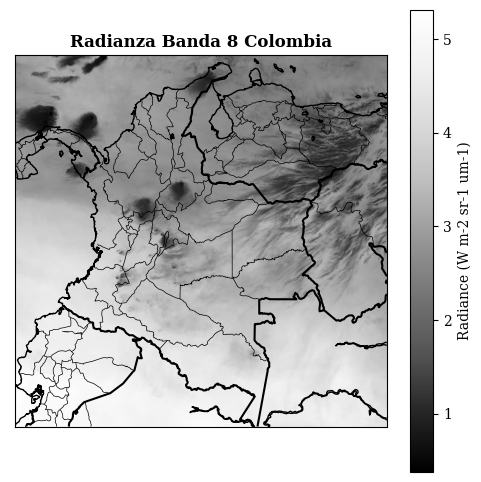

In [25]:
lon_plot = nuevo.variables['lon'][:]
lat_plot = nuevo.variables['lat'][:]
rad_plot = nuevo.variables['Rad8'][:]

fig = plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

map = Basemap(projection='merc',llcrnrlon=-81.03,llcrnrlat=-4.1,urcrnrlon=-64,urcrnrlat=12.78,resolution='i')

map.drawcoastlines()
map.drawcountries(linewidth=1.5)
map.drawstates()

im = map.imshow(rad_plot, cmap='Greys_r')
cb = fig.colorbar(im, orientation='vertical')
#cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title("Radianza Banda 8 Colombia", weight="bold")
plt.show()

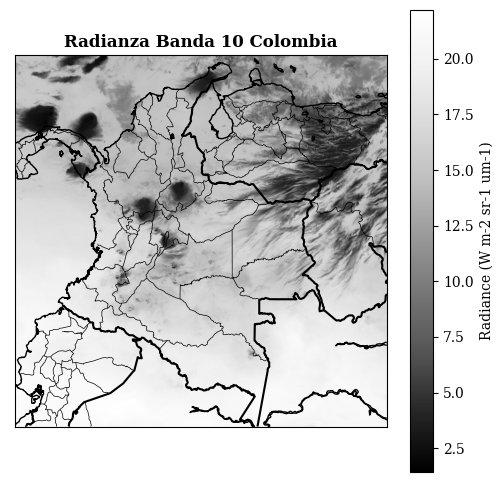

In [27]:
lon_plot = nuevo.variables['lon'][:]
lat_plot = nuevo.variables['lat'][:]
rad_plot = nuevo.variables['Rad10'][:]

fig = plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

map = Basemap(projection='merc',llcrnrlon=-81.03,llcrnrlat=-4.1,urcrnrlon=-64,urcrnrlat=12.78,resolution='i')

map.drawcoastlines()
map.drawcountries(linewidth=1.5)
map.drawstates()

im = map.imshow(rad_plot, cmap='Greys_r')
cb = fig.colorbar(im, orientation='vertical')
#cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title("Radianza Banda 10 Colombia", weight="bold")
plt.show()

## Solo radianza banda 13

In [13]:
ds_13 = Dataset('RadF_B13_20200320060018.nc','w',format='NETCDF4')

ds_13.createDimension('x',len(x_col))
ds_13.createDimension('y',len(y_col))
    
fill = ds8.variables['Rad']._FillValue    

dsRad13 = ds_13.createVariable('Rad13','i2',('y','x',),fill_value=fill)

dsRad13.setncatts({k: ds13.variables['Rad'].getncattr(k) for k in ds13.variables['Rad'].ncattrs()})

dsRad13[:] = Rad13

ds_13.close()



In [14]:
rad_13 = Dataset('RadF_B13_20200320060018.nc')

In [15]:
rad_13

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(920), y(920)
    variables(dimensions): int16 Rad13(y, x)
    groups: 

In [6]:
(8.5*24*365)*1

74460.0